### Imports

In [2]:

import numpy as np 
import pandas as pd
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,UpSampling2D,Concatenate,Input,Softmax,Conv2DTranspose
from tensorflow.keras import Model, layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from tensorflow.keras.optimizers import Adam



### Constants

In [3]:
EPOCHS=10
BATCH_SIZE=10
HEIGHT=256
WIDTH=256
N_CLASSES=13

### Utility functions for data loading

In [4]:
def LoadImage(name, path):
    img = Image.open(os.path.join(path, name))
    img = np.array(img)
    
    image = img[:,:256]
    mask = img[:,256:]
    
    # print(image.shape, mask.shape)
    return image, mask


def bin_image(mask):
    bins = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240])
    new_mask = np.digitize(mask, bins)
    return new_mask

def getSegmentationArr(image, classes, width=WIDTH, height=HEIGHT):
    seg_labels = np.zeros((height, width, classes))
    img = image[:, : , 0]

    for c in range(classes):
        seg_labels[:, :, c] = (img == c ).astype(int)
    return seg_labels

def give_color_to_seg_img(seg, n_classes=N_CLASSES):
    
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

classes = 13

In [5]:
train_folder = "./cityscapes_data/train"
valid_folder = "./cityscapes_data/val"

num_of_training_samples = len(os.listdir(train_folder)) 
num_of_valid_samples = len(os.listdir(valid_folder))

def DataGenerator(path, batch_size=BATCH_SIZE, classes=N_CLASSES):
    files = os.listdir(path)
    print(files)
    while True:
        for i in range(0, len(files), batch_size):
            batch_files = files[i : i+batch_size]
            imgs=[]
            segs=[]
            for file in batch_files:
                image, mask = LoadImage(file, path)
                mask_binned = bin_image(mask)
                labels = getSegmentationArr(mask_binned, classes)

                imgs.append(image)
                segs.append(labels)

            yield np.array(imgs), np.array(segs)

### Loading train and validation data

In [6]:
train_gen = DataGenerator(train_folder, batch_size=BATCH_SIZE)
val_gen = DataGenerator(valid_folder, batch_size=BATCH_SIZE)

In [7]:
imgs, segs = next(train_gen)
imgs.shape, segs.shape

['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '1001.jpg', '1002.jpg', '1003.jpg', '1004.jpg', '1005.jpg', '1006.jpg', '1007.jpg', '1008.jpg', '1009.jpg', '101.jpg', '1010.jpg', '1011.jpg', '1012.jpg', '1013.jpg', '1014.jpg', '1015.jpg', '1016.jpg', '1017.jpg', '1018.jpg', '1019.jpg', '102.jpg', '1020.jpg', '1021.jpg', '1022.jpg', '1023.jpg', '1024.jpg', '1025.jpg', '1026.jpg', '1027.jpg', '1028.jpg', '1029.jpg', '103.jpg', '1030.jpg', '1031.jpg', '1032.jpg', '1033.jpg', '1034.jpg', '1035.jpg', '1036.jpg', '1037.jpg', '1038.jpg', '1039.jpg', '104.jpg', '1040.jpg', '1041.jpg', '1042.jpg', '1043.jpg', '1044.jpg', '1045.jpg', '1046.jpg', '1047.jpg', '1048.jpg', '1049.jpg', '105.jpg', '1050.jpg', '1051.jpg', '1052.jpg', '1053.jpg', '1054.jpg', '1055.jpg', '1056.jpg', '1057.jpg', '1058.jpg', '1059.jpg', '106.jpg', '1060.jpg', '1061.jpg', '1062.jpg', '1063.jpg', '1064.jpg', '1065.jpg', '1066.jpg', '1067.jpg', '1068.jpg', '1069.jpg', '107.jpg', '1070.jpg', '1071.jpg', '1072.jpg', '1073.jpg', '107

((10, 256, 256, 3), (10, 256, 256, 13))

### Visualizing image from the data with mask and masked image

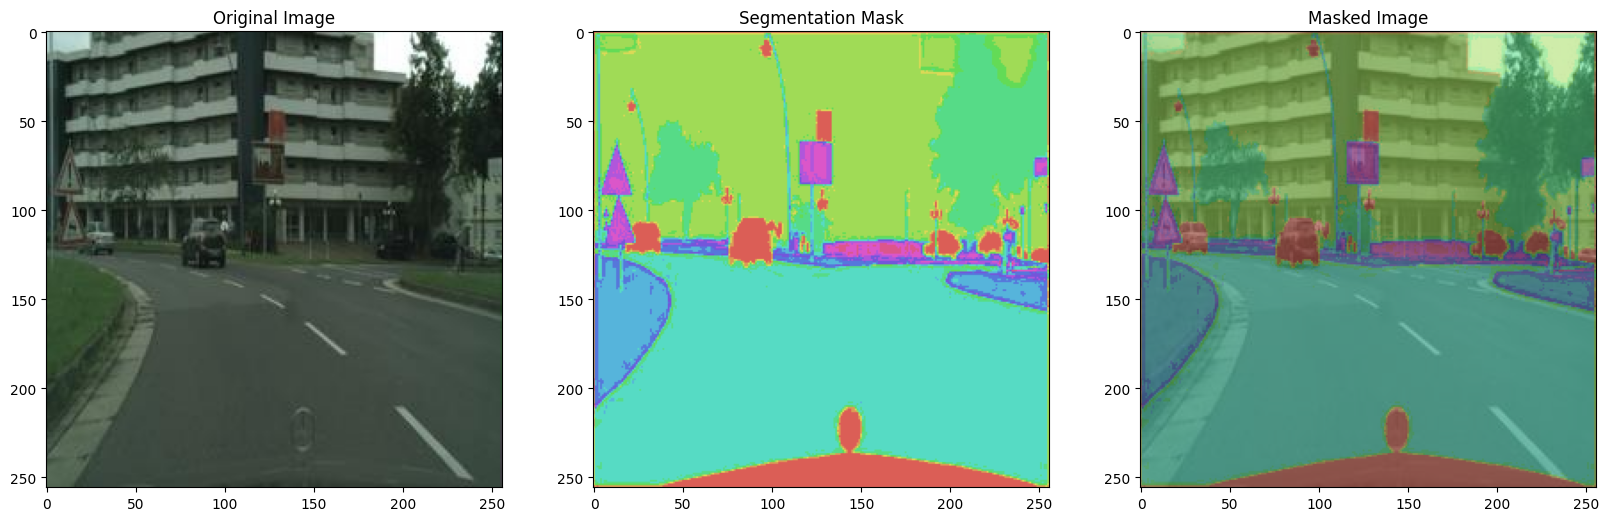

In [8]:
image = imgs[0]
mask = give_color_to_seg_img(np.argmax(segs[0], axis=-1))
masked_image = cv2.addWeighted(image/255, 0.5, mask, 0.5, 0)

fig, axs = plt.subplots(1, 3, figsize=(20,20))
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[1].imshow(mask)
axs[1].set_title('Segmentation Mask')
axs[2].imshow(masked_image)
axs[2].set_title('Masked Image')
plt.show()

### Fully Convolutional Network (FCN)

In [41]:
def fcn_model():
    inputs = tf.keras.Input((HEIGHT, WIDTH, 3))
    
    # Encoding layers
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Bottleneck layers
    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    
    # Decoding layers
    up5 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = layers.concatenate([up5, conv3], axis=3)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)
    
    up6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = layers.concatenate([up6, conv2], axis=3)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)
    
    up7 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv6)
    conv7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    
    # Output layer
    output = layers.Conv2D(N_CLASSES, (1, 1), activation='softmax')(conv7)
    
    model = Model(inputs=inputs, outputs=output)
    return model




In [42]:
model = fcn_model()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])


In [43]:
TRAIN_STEPS = num_of_training_samples//BATCH_SIZE+1
VAL_STEPS = num_of_valid_samples//BATCH_SIZE+1

model_history = model.fit(train_gen, validation_data=val_gen, steps_per_epoch=TRAIN_STEPS, 
                    validation_steps=VAL_STEPS, epochs=EPOCHS)

Epoch 1/10
132/298 ━━━━━━━━━━━━━━━━━━━━ 12:49 5s/step - acc: 0.2725 - loss: 2.3667

KeyboardInterrupt: 

In [14]:
checkpoint = ModelCheckpoint('seg_model.keras', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

### U-Net network architecture

In [11]:
def UNet():
    inputs = tf.keras.Input((WIDTH, HEIGHT, 3))
    
    # Encoding layers
    conv1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Bottleneck layers
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)
    
    # Decoding layers
    up6 = layers.UpSampling2D(size=(2, 2))(conv5)
    up6 = layers.concatenate([up6, conv4], axis=3)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)
    
    up7 = layers.UpSampling2D(size=(2, 2))(conv6)
    up7 = layers.concatenate([up7, conv3], axis=3)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)
    
    up8 = layers.UpSampling2D(size=(2, 2))(conv7)
    up8 = layers.concatenate([up8, conv2], axis=3)
    conv8 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)
    
    up9 = layers.UpSampling2D(size=(2, 2))(conv8)
    up9 = layers.concatenate([up9, conv1], axis=3)
    conv9 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
    conv9 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(conv9)
    
    # Output layer
    output = layers.Conv2D(N_CLASSES, (1, 1), activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=output)
    return model


In [12]:
model_unet = UNet()
model_unet.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])
model_unet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 256, 256,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 256, 256,  │      2,320 │ conv2d_15[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 128, 128,  │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_17[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_6[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 32, 32,    │          0 │ up_sampling2d[0]

 Total params: 1,962,829 (7.49 MB)

 Trainable params: 1,962,829 (7.49 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
TRAIN_STEPS = num_of_training_samples//BATCH_SIZE+1
VAL_STEPS = num_of_valid_samples//BATCH_SIZE+1

model_unet_hsitory = model_unet.fit(train_gen, validation_data=val_gen, steps_per_epoch=TRAIN_STEPS, 
                    validation_steps=VAL_STEPS, epochs=EPOCHS, callbacks = checkpoint)

Epoch 1/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - acc: 0.2602 - loss: 2.3328['1.jpg', '10.jpg', '100.jpg', '101.jpg', '102.jpg', '103.jpg', '104.jpg', '105.jpg', '106.jpg', '107.jpg', '108.jpg', '109.jpg', '11.jpg', '110.jpg', '111.jpg', '112.jpg', '113.jpg', '114.jpg', '115.jpg', '116.jpg', '117.jpg', '118.jpg', '119.jpg', '12.jpg', '120.jpg', '121.jpg', '122.jpg', '123.jpg', '124.jpg', '125.jpg', '126.jpg', '127.jpg', '128.jpg', '129.jpg', '13.jpg', '130.jpg', '131.jpg', '132.jpg', '133.jpg', '134.jpg', '135.jpg', '136.jpg', '137.jpg', '138.jpg', '139.jpg', '14.jpg', '140.jpg', '141.jpg', '142.jpg', '143.jpg', '144.jpg', '145.jpg', '146.jpg', '147.jpg', '148.jpg', '149.jpg', '15.jpg', '150.jpg', '151.jpg', '152.jpg', '153.jpg', '154.jpg', '155.jpg', '156.jpg', '157.jpg', '158.jpg', '159.jpg', '16.jpg', '160.jpg', '161.jpg', '162.jpg', '163.jpg', '164.jpg', '165.jpg', '166.jpg', '167.jpg', '168.jpg', '169.jpg', '17.jpg', '170.jpg', '171.jpg', '172.jpg', '173.jpg', '174.jpg', '17

In [16]:
model_unet.load_weights("./seg_model.keras")

### Visualizing loss and accuracy during epochs for Unet

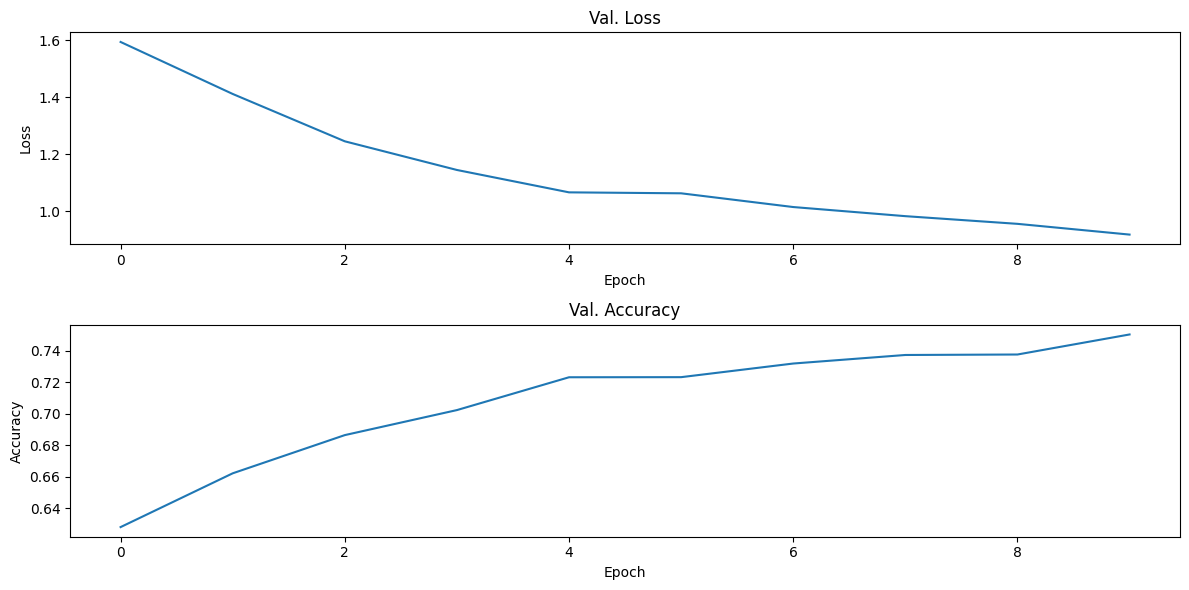

In [17]:
loss = model_unet_hsitory.history["val_loss"]
acc = model_unet_hsitory.history["val_acc"]

plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.title("Val. Loss")
plt.plot(loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(212)
plt.title("Val. Accuracy")
plt.plot(acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

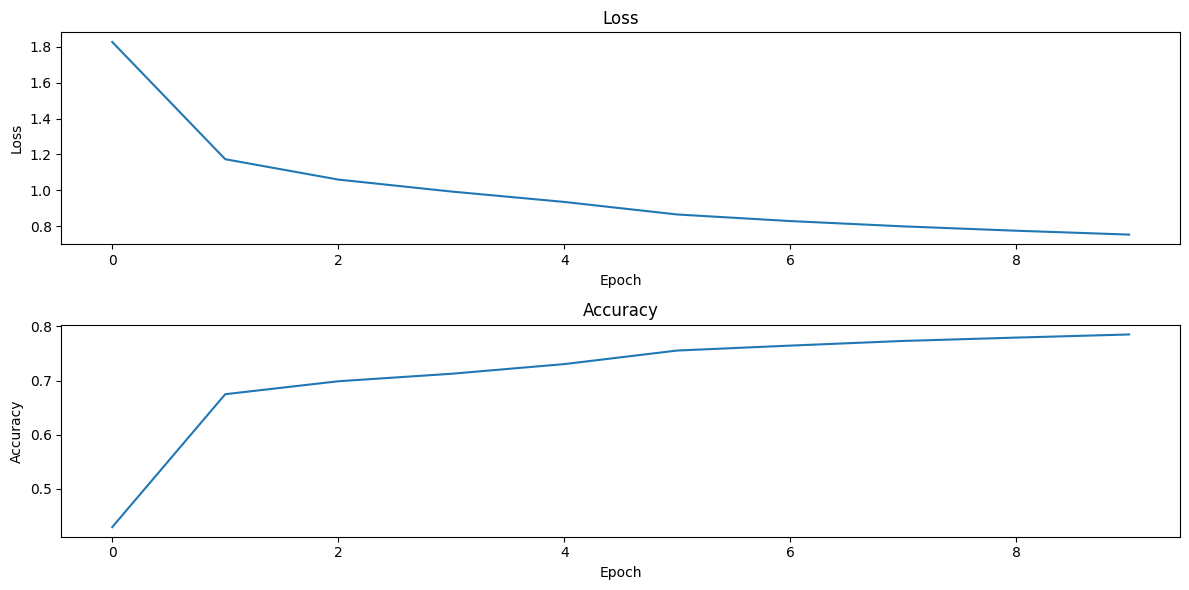

In [22]:
loss = model_unet_hsitory.history["loss"]
acc = model_unet_hsitory.history["acc"]

plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(212)
plt.title("Accuracy")
plt.plot(acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()



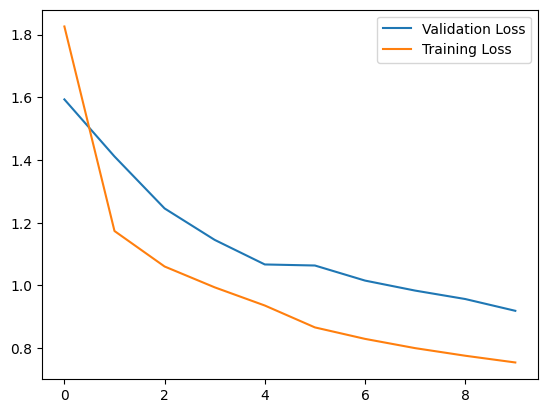

In [25]:
val_loss = model_unet_hsitory.history["val_loss"]
loss = model_unet_hsitory.history["loss"]

plt.plot(val_loss, label="Validation Loss")
plt.plot(loss, label="Training Loss")

plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


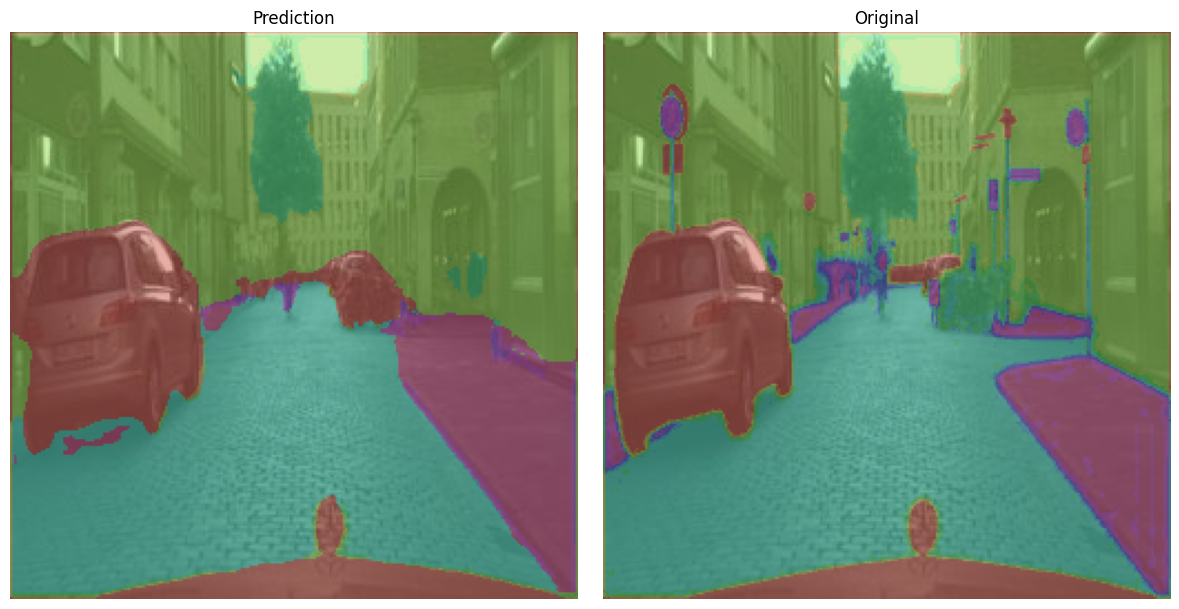

In [38]:
max_show = 1
imgs, segs = next(val_gen)
pred = model_unet.predict(imgs)

for i in range(max_show):
    _p = give_color_to_seg_img(np.argmax(pred[i], axis=-1))
    _s = give_color_to_seg_img(np.argmax(segs[i], axis=-1))

    predimg = cv2.addWeighted(imgs[i]/255, 0.5, _p, 0.5, 0)
    trueimg = cv2.addWeighted(imgs[i]/255, 0.5, _s, 0.5, 0)
    
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.title("Prediction")
    plt.imshow(predimg)
    plt.axis("off")
    plt.subplot(122)
    plt.title("Original")
    plt.imshow(trueimg)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("pred_"+str(i)+".png", dpi=150)
    plt.show()